# Perform decomposition of tracer anomalies

The tracer anomalies on a $z$-level are decomposed into
1. "spice" component: variations of the tracer on isopycnal surfaces; and
1. "heave" component: variations of the tracer due to variation in the isopycnal found at the $z$-level.

The "spice" anomaly is the difference between the annual mean tracer concentration and the long-term mean of the tracer concentration on the isopycnal $\rho(t)$ found at depth $z$ at time $t$:

$X_S' = X - \left<X\right>_{\rho(t)}$

The "heave" component is the difference between the climatological mean of the tracer on the isopycnal surface and that at fixed depth:

$X_H' = \left<X\right>_{\rho(t)} - \left<X\right>_{z}$

The total anomaly, by construction, is the sum

$X' = X_S' + X_H'$

See also [Doney et al. 2007](https://journals.ametsoc.org/doi/abs/10.1175/JPO3089.1).

In [1]:
%matplotlib inline
import os
from subprocess import call
from tqdm import tqdm_notebook as tqdm

import xarray as xr
import numpy as np
import cftime
import dask

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import geotools as gt
import plottools as pt
import project as P

USER = os.environ['USER']

## get access to compute resources

In [2]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [3]:
Nnodes = 4
cluster.scale(9*Nnodes)

## pre-process: regrid to sigma coords

Demonstrate selection of a sigma coordinate. 

```
npac_isel = {'nlat':slice(187,331),'nlon':slice(137,276)}

files = sorted(glob('/glade/p_old/decpred/CESM-DPLE/monthly/PD/*.nc'))
dsi = xr.open_mfdataset(files[::100],decode_times=False)
dsi = dsi.sel(z_t=200e2,method='nearest')
dsi = dsi.isel(**npac_isel)

dsi.PD.min().values

    array(1.0234147, dtype=float32)

dsi.PD.max().values
  
    array(1.0271196, dtype=float32)
    
dsi = xr.open_mfdataset('/glade/p_old/decpred/CESM-DPLE_POPCICEhindcast/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.PD.024901-031612.nc',decode_times=False)    
dsi = dsi.sel(z_t=200e2,method='nearest')
dsi = dsi.isel(**npac_isel)

dsi.PD.min().values

    array(1.0239267, dtype=float32)

dsi.PD.max().values
  
    array(1.026945, dtype=float32)
    
dsigma = 0.05
sigma_start = 23.4-dsigma/2
sigma_stop = 27.12+dsigma/2

sigma_edges = np.arange(sigma_start,sigma_stop+dsigma,dsigma)
sigma = np.average(np.vstack((sigma_edges[0:-1],sigma_edges[1:])),axis=0)
print(sigma)
print(len(sigma))    
    
[23.4  23.45 23.5  23.55 23.6  23.65 23.7  23.75 23.8  23.85 23.9  23.95
 24.   24.05 24.1  24.15 24.2  24.25 24.3  24.35 24.4  24.45 24.5  24.55
 24.6  24.65 24.7  24.75 24.8  24.85 24.9  24.95 25.   25.05 25.1  25.15
 25.2  25.25 25.3  25.35 25.4  25.45 25.5  25.55 25.6  25.65 25.7  25.75
 25.8  25.85 25.9  25.95 26.   26.05 26.1  26.15 26.2  26.25 26.3  26.35
 26.4  26.45 26.5  26.55 26.6  26.65 26.7  26.75 26.8  26.85 26.9  26.95
 27.   27.05 27.1  27.15]
76
```

``proc_remap_to_sigma.py`` run for Cheyenne login node; uses ``workflow.task_manager`` and ``ncops``, which use Slurm and regrid in time-chunks on dav cluster.

## Load annual mean datasets

In [4]:
import importlib
importlib.reload(P)

clobber = False

case = 'g.e11_LENS.GECOIAF.T62_g16.009'
datestr = '024901-031612'
year_range = np.array((249,316))+1699

npac_isel = {'nlat':slice(187,331),'nlon':slice(137,276)}

variables = ['O2','SALT','TEMP']
varstr = '.'.join(variables)

### read z-coordinate annual mean data

In [5]:
%%time
importlib.reload(P)
dsz = P.annmean_collection(base_dataset = 'FOSI_monthly',
                           variables = variables+['PD'], 
                           isel_name = 'npac',
                           isel = npac_isel,
                           clobber = clobber)

#-- convert to sigma-theta units
dsz = dsz.sel(z_t=200e2,method='nearest')
dsz.PD.values = (dsz.PD - 1.)*1000.
dsz = dsz.compute()

reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.O2.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.SALT.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.TEMP.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.PD.zarr
CPU times: user 7.2 s, sys: 1.21 s, total: 8.41 s
Wall time: 6min 53s


### read sigma-coordinate annual mean data

In [6]:
dss = P.annmean_collection(base_dataset = 'FOSI_monthly_sigma',
                           variables = ['O2'], 
                           isel_name = 'npac',
                           isel = npac_isel,
                           clobber = clobber)

reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly_sigma.ann.npac.O2.zarr


## compute long-term means

In [7]:
dsz_clm = dsz.mean('time').compute()
dss_clm = dss.mean('time').compute()

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Compute $\left<X\right>_{\rho(t)}$ and anomaly decomposition

In [8]:

rho_coord = dss_clm.sigma.values
ds = xr.Dataset({v:dsz[v] for v in dsz.variables if 'time' not in dsz[v].dims})
ds['time'] = dsz.time
for v in ['O2']:
    print(f'computing {v}')
    tracer_on_rho_t = np.full_like(dsz[v],fill_value=np.nan)
    for i in tqdm(range(len(dsz.nlon))):
        for j in range(len(dsz.nlat)):        
            rho_t = dsz.PD.values[:,j,i]
            tracer_on_rho_clm = dss_clm[v].values[:,j,i]
            tracer_on_rho_t[:,j,i] = np.interp(rho_t,rho_coord,tracer_on_rho_clm)

    ds[v+'_on_rho_t'] = xr.DataArray(tracer_on_rho_t,dims=('time','nlat','nlon'))
    ds[v+'_spice'] = dsz[v] - ds[v+'_on_rho_t']
    ds[v+'_heave'] = ds[v+'_on_rho_t'] - dsz_clm[v]    
    ds[v+'_total'] = dsz[v] - dsz_clm[v] # also equal to heave + spice


computing O2


## perform regression

In [9]:
for v in ['O2']:
    print(f'computing {v}')
    ds[f'{v}_heave_on_total'] = xr.full_like(ds[f'{v}_total'].isel(time=0),fill_value=np.nan)
    ds[f'{v}_spice_on_total'] = xr.full_like(ds[f'{v}_total'].isel(time=0),fill_value=np.nan)    
    for i in tqdm(range(len(dsz.nlon))):
        for j in range(len(dsz.nlat)): 
            x = ds[v+'_total'].values[:,j,i]
            if np.isnan(x).all(): continue
            for flv in ['heave','spice']:                
                y = ds[f'{v}_{flv}'].values[:,j,i]     
                pf = np.polyfit(x,y,1)
                ds[f'{v}_{flv}_on_total'][j,i] = pf[0]

computing O2


In [10]:
extent = [120,260,10,65]
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


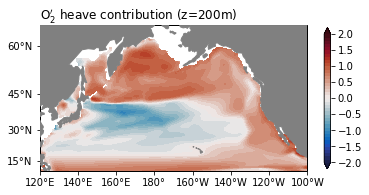

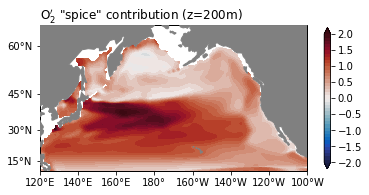

In [11]:

cf_specs = {'levels':np.arange(-2,2+0.1,0.1),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_heave_on_total.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('O$_2^\prime$ heave contribution (z=200m)',loc='left')

plt.savefig(f'{P.dirf}/npac-200m-O2-anom-decomp-heave.pdf',bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_spice_on_total.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('O$_2^\prime$ "spice" contribution (z=200m)',loc='left')

plt.savefig(f'{P.dirf}/npac-200m-O2-anom-decomp-spice.pdf',bbox_inches='tight')

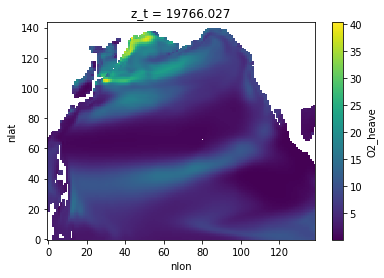

In [12]:
ds.O2_heave.std('time').plot()

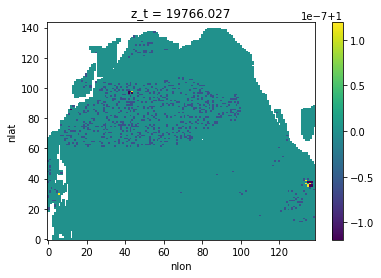

In [13]:
(ds.O2_heave_on_total+ds.O2_spice_on_total).plot()

## make a regional plot

In [14]:
dsr = P.regional_mean(ds.drop('z_t'))
dsr = dsr.compute()

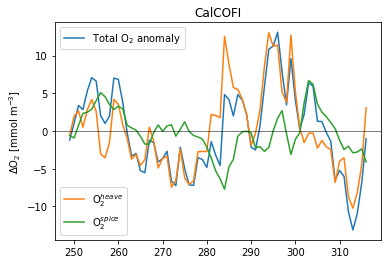

In [21]:
fig = plt.figure()
axL = fig.add_subplot(111)
pT, = axL.plot(dsr.time,dsr.O2_total,label='Total O$_2$ anomaly')
pH, = axL.plot(dsr.time,dsr.O2_heave,label='O$_2^{heave}$')
pS, = axL.plot(dsr.time,dsr.O2_spice,label='O$_2^{spice}$')

axL.axhline(0.,color='k',linewidth=0.5)
axL.set_ylabel('$\Delta$O$_2$ [mmol m$^{-3}$]')

fL = plt.legend(handles=[pT],loc='upper left')
ax = plt.gca().add_artist(fL)

plt.legend(handles=[pH,pS],loc='lower left')

plt.subplots_adjust(right=0.88)

axL.set_title(dsr.region.values[0])
plt.savefig(f'{P.dirf}/CalCOFI-200m-O2-anom-decomp-ts.pdf',bbox_inches='tight')